In [1]:
pip install "tensorflow>=1.15.2,<2.0"

     |████████████████████████████████| 110.5MB 96kB/s 
     |████████████████████████████████| 51kB 7.5MB/s 
     |████████████████████████████████| 20.1MB 1.2MB/s 
     |████████████████████████████████| 3.8MB 52.3MB/s 
     |████████████████████████████████| 512kB 41.6MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7540 sha256=ebfab88fb144b78b27053364737f3b1b2be3e58a83ca7a631c74240fdda39286
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninsta

In [2]:
pip install "tensorflow-gpu>=1.15.2,<2.0"

     |████████████████████████████████| 411.0MB 28kB/s 


In [3]:
pip install ampligraph

     |████████████████████████████████| 153kB 4.1MB/s 
     |████████████████████████████████| 2.7MB 42.3MB/s 
     |████████████████████████████████| 81kB 11.8MB/s 
     |████████████████████████████████| 9.2MB 53.2MB/s 
     |████████████████████████████████| 235kB 53.0MB/s 
     |████████████████████████████████| 51kB 7.6MB/s 
     |████████████████████████████████| 92kB 12.1MB/s 
     |████████████████████████████████| 122kB 39.5MB/s 
     |████████████████████████████████| 102kB 14.3MB/s 
     |████████████████████████████████| 92kB 12.7MB/s 
     |████████████████████████████████| 71kB 10.5MB/s 
     |████████████████████████████████| 51kB 8.1MB/s 
     |████████████████████████████████| 563kB 55.9MB/s 
     |████████████████████████████████| 51kB 8.6MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: sphinx-rtd-theme 0.5.2 has requirement docutils<0.17, but you'll have docutils 0.17 which is incompatible.
  Fo

In [4]:
pip install rdflib

In [5]:
pip install seaborn adjustText

  Created wheel for adjustText: filename=adjustText-0.7.3-cp37-none-any.whl size=7100 sha256=72d1e12afe55bfe79cf9e1c52867d25e663dc8e2d852d69182848a3d71d94dda
  Stored in directory: /root/.cache/pip/wheels/41/95/74/7d347e136d672f8bc28e937032bc92baf4f80856763a7e7b72
Successfully built adjustText


In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ampligraph
import rdflib
import tensorflow as tf
import seaborn as sns
import pickle
from ampligraph.evaluation import train_test_split_no_unseen 
from ampligraph.latent_features import ComplEx
from ampligraph.latent_features import TransE
from ampligraph.utils import save_model
from ampligraph.latent_features import restore_model
from sklearn.decomposition import PCA
from ampligraph.discovery import find_clusters
from sklearn.cluster import KMeans
from adjustText import adjust_text
from sklearn.metrics.pairwise import cosine_similarity
from google.colab import files
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# **Import KG**

In [9]:
g = rdflib.Graph()
g.parse('/content/gdrive/My Drive/foodb_openfoodfact_statements.nq', format='nquads')
print(len(g))

2868826


# **Convert KG to PD**

In [10]:
rows = []
for s, p, o in g:
    rows.append([s, p, o])

In [11]:
triples = pd.DataFrame(rows, columns=['subject', 'predicate', 'object'])

# **Train KG Embeddings**

In [12]:
X_train, X_valid = train_test_split_no_unseen(np.array(triples), test_size=10000)
X_train = X_train.astype('<U48')
X_valid = X_valid.astype('<U48')
print('Train set size: ', X_train.shape)
print('Test set size: ', X_valid.shape)

Train set size:  (2858826, 3)
Test set size:  (10000, 3)


In [ ]:
model = ComplEx(batches_count=50,
                epochs=300,
                k=100,
                eta=20,
                optimizer='adam', 
                optimizer_params={'lr':1e-4},
                loss='multiclass_nll',
                regularizer='LP', 
                regularizer_params={'p':3, 'lambda':1e-5}, 
                seed=0, 
                verbose=True)
tf.logging.set_verbosity(tf.logging.ERROR)
model.fit(X_train)

Average Loss:   0.112755: 100%|██████████| 300/300 [1:51:27<00:00, 22.29s/epoch]


In [ ]:
save_model(model, model_name_path = 'complex.pkl')
files.download('complex.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model = TransE(batches_count=50,
                epochs=300,
                k=100,
                eta=20,
                optimizer='adam', 
                optimizer_params={'lr':1e-4},
                loss='multiclass_nll',
                regularizer='LP', 
                regularizer_params={'p':3, 'lambda':1e-5}, 
                seed=0, 
                verbose=True)
tf.logging.set_verbosity(tf.logging.ERROR)
model.fit(X_train)

Average Loss:   0.193462: 100%|██████████| 300/300 [29:36<00:00,  5.92s/epoch]


In [ ]:
save_model(model, model_name_path = 'transE.pkl')
files.download('transE.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [134]:
model = restore_model('/content/gdrive/My Drive/complex.pkl')
#model = restore_model('/content/gdrive/My Drive/transE.pkl')

# **Find Similarities**

In [135]:
def Filter(string, substring):
    return [str for str in string if
             any(sub in str for sub in substring)]
string = X_train[:, 0]
substring = ['https://foodb.ca/foods/0', 'https://foodb.ca/foods/1', 'https://foodb.ca/foods/2', 'https://foodb.ca/foods/3', 
          'https://foodb.ca/foods/4', 'https://foodb.ca/foods/5', 'https://foodb.ca/foods/6', 'https://foodb.ca/foods/7', 
          'https://foodb.ca/foods/8', 'https://foodb.ca/foods/9']
foods = (Filter(string, substring))
foods = np.unique(foods)
len(foods)

893

In [136]:
food_embeddings = dict(zip(foods, model.get_embeddings(foods)))

In [137]:
embeddings_2d = PCA(n_components=2).fit_transform(np.array([i for i in food_embeddings.values()]))

# **Method 1: K-Means Clustering**

In [138]:
clustering_algorithm = KMeans(n_clusters=23, n_init=50, max_iter=500, random_state=0)
clusters = find_clusters(foods, model, clustering_algorithm, mode='entity')

In [139]:
plot_df = pd.DataFrame({"foods": foods, 
                        "embedding1": embeddings_2d[:, 0], 
                        "embedding2": embeddings_2d[:, 1],
                        "cluster": "cluster" + pd.Series(clusters).astype(str)})
plot_df['foods'] = plot_df['foods'].map(lambda x: x.lstrip('https://foodb.ca/foods/'))

food = pd.read_csv('/content/gdrive/My Drive/BMKG/Food.csv')
food = food.replace('NA',np.nan)
food = food[['id', 'name', 'food_group', 'food_subgroup']]
food = food.dropna()

for i in range(len(food)):
  food_id = food['id'].iloc[i]
  food_name = food[food['id'] == food_id]['name'].iloc[0]
  food_group = food[food['id'] == food_id]['food_group'].iloc[0]
  food_subgroup = food[food['id'] == food_id]['food_subgroup'].iloc[0]
  index = plot_df[plot_df['foods'] == str(food_id)].index
  plot_df.at[index, 'food_name'] = food_name
  plot_df.at[index, 'food_group'] = food_group
  plot_df.at[index, 'food_subgroup'] = food_subgroup

plot_df = plot_df.dropna()

In [140]:
def plot_10(plot_df):
  plot_df_10 = plot_df[:10]
  plt.title('Knowledge Graph Embeddings: 10 Foods')
  ax = sns.scatterplot(data=plot_df_10, x="embedding1", y="embedding2", hue='cluster')
  texts = []
  for i, point in plot_df_10.iterrows():
    texts.append(plt.text(point['embedding1'], point['embedding2'], str(point['food_name'])))
  adjust_text(texts)

In [141]:
def plot_cluster(cluster_name):
  cluster = plot_df[plot_df['cluster'] == cluster_name]
  plt.figure(figsize=(20,12))
  plt.title('Knowledge Graph Embeddings:' + str(cluster_name))
  ax = sns.scatterplot(data=cluster, x="embedding1", y="embedding2", hue='cluster')
  texts = []
  for i, point in cluster.iterrows():
    texts.append(plt.text(point['embedding1'], point['embedding2'], str(point['food_name'])+'|'+str(point['food_group'])))
  adjust_text(texts)

In [142]:
from scipy.spatial import distance
dst_watercress = []
dst_lard = []
dst_pizza = []
a_watercress = (watercress['embedding1'], watercress['embedding2'])
a_lard = (lard['embedding1'], lard['embedding2'])
a_pizza = (pizza['embedding1'], pizza['embedding2'])
for i in range(len(plot_df)):
  b = (plot_df['embedding1'].iloc[i], plot_df['embedding2'].iloc[i])
  dst_watercress.append(distance.euclidean(a_watercress, b))
  dst_lard.append(distance.euclidean(a_lard, b))
  dst_pizza.append(distance.euclidean(a_pizza, b))
plot_df['dst_watercress'] = dst_watercress
plot_df['dst_lard'] = dst_lard
plot_df['dst_pizza'] = dst_pizza

In [143]:
watercress = plot_df[plot_df['food_name'] == 'Watercress']
watercress_cluster = watercress['cluster'].iloc[0]
lard = plot_df[plot_df['food_name'] == 'Lard']
lard_cluster = lard['cluster'].iloc[0]
pizza = plot_df[plot_df['food_name'] == 'Pizza']
pizza_cluster = pizza['cluster'].iloc[0]

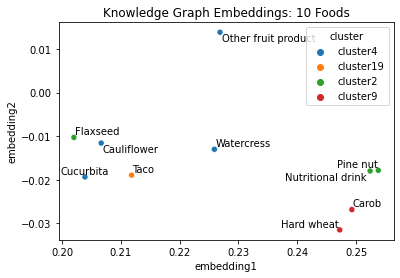

In [144]:
plot_10(plot_df.sort_values(by=['dst_watercress']))

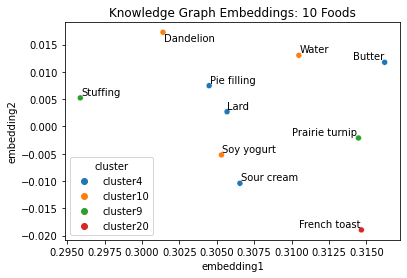

In [145]:
plot_10(plot_df.sort_values(by=['dst_lard']))

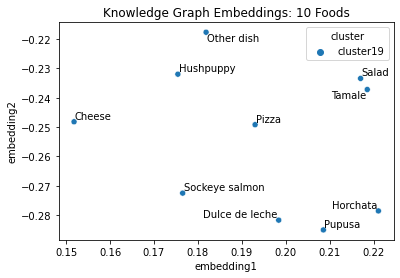

In [146]:
plot_10(plot_df.sort_values(by=['dst_pizza']))

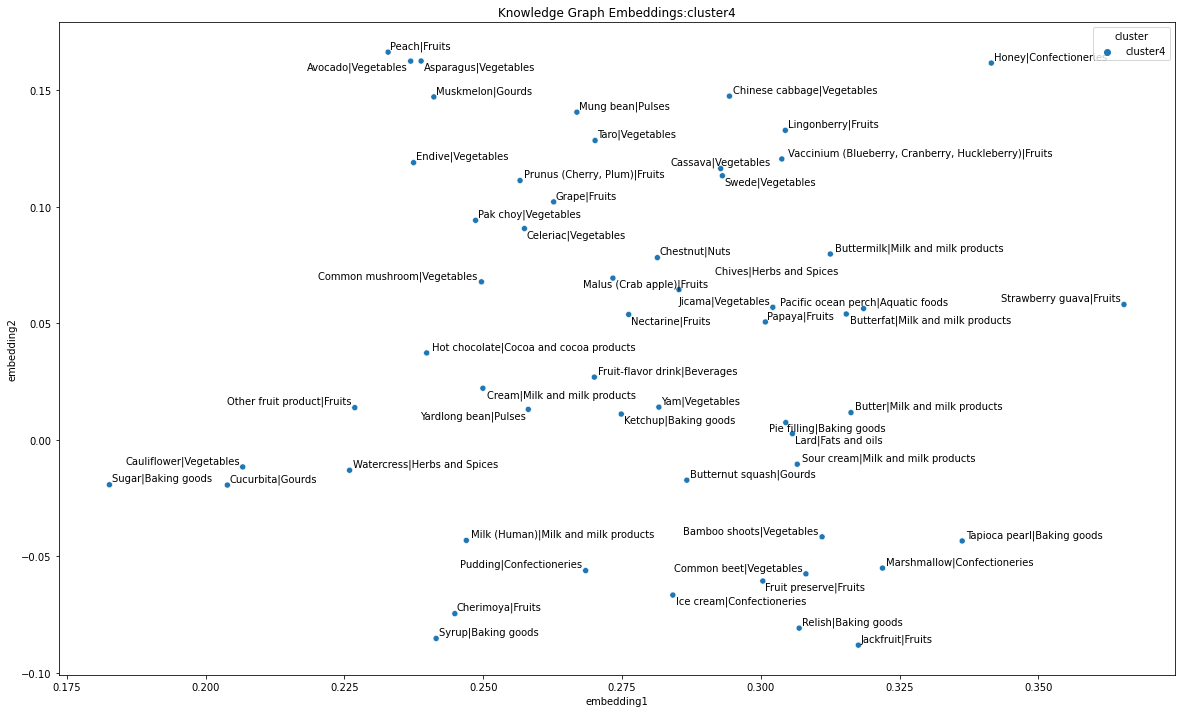

In [147]:
plot_cluster(watercress_cluster)

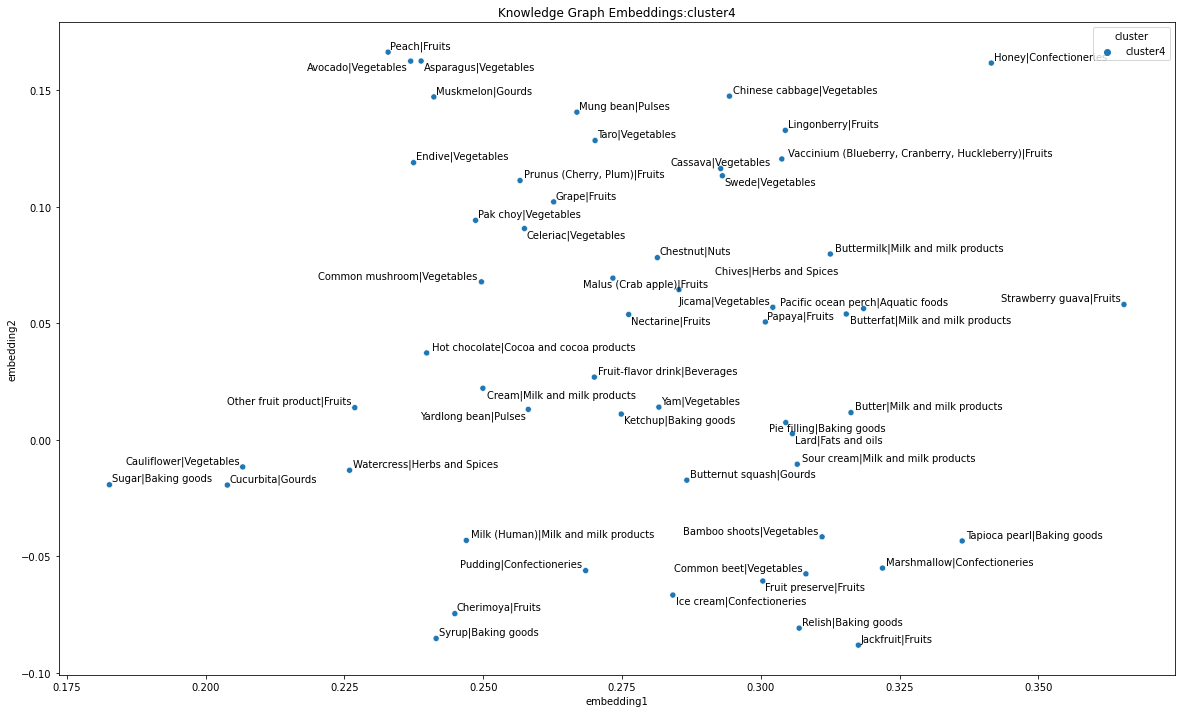

In [148]:
plot_cluster(lard_cluster)

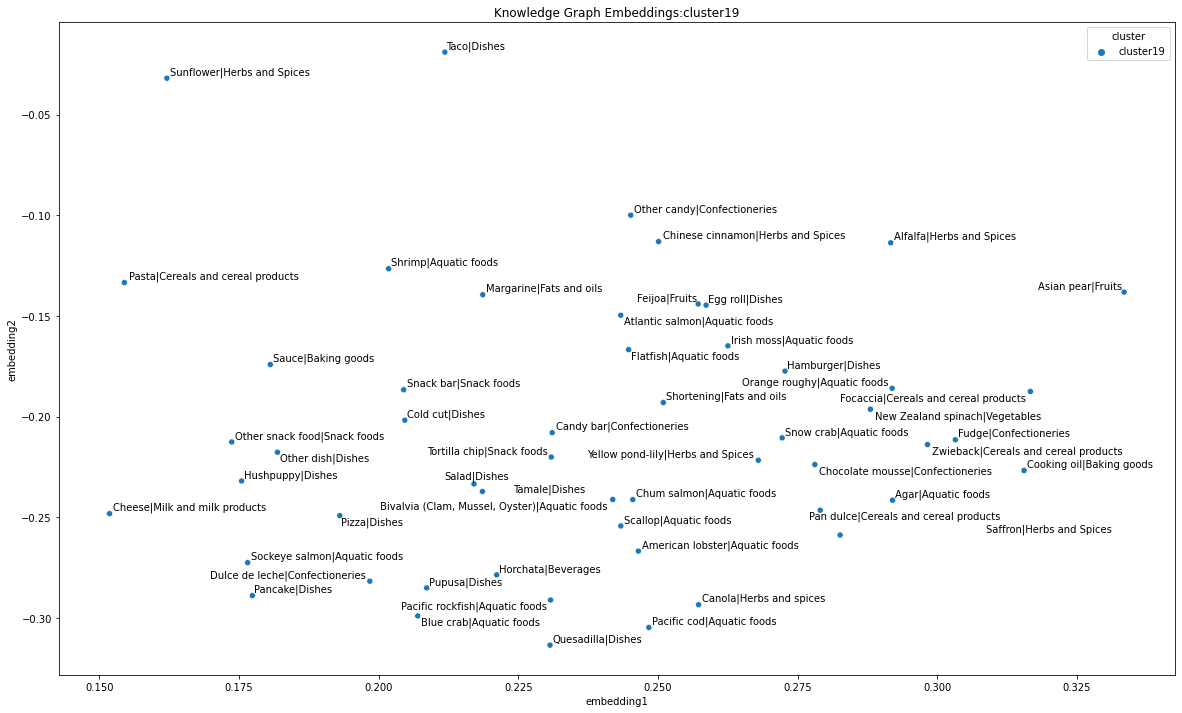

In [149]:
plot_cluster(pizza_cluster)

# **Method 2: Cosine Similarity**

In [152]:
embeddings = np.array([plot_df['embedding1'], plot_df['embedding2']]).transpose()
cosine_similarity = cosine_similarity(embeddings)
df = pd.DataFrame(data=cosine_similarity, columns=plot_df['food_name'])
df.index = plot_df['food_name']

In [153]:
temp = df['Watercress']
sorted_temp = temp.sort_values(axis=0, ascending=False)
sorted_temp[:11]

food_name
Watercress             1.000000
Turkey                 0.999999
Cauliflower            0.999999
Butternut squash       0.999996
French toast           0.999996
Green lentil           0.999992
Jerusalem artichoke    0.999991
Plains prickly pear    0.999988
Blue cheese            0.999983
Flaxseed               0.999978
Chicory roots          0.999969
Name: Watercress, dtype: float32

In [154]:
temp = df['Lard']
sorted_temp = temp.sort_values(axis=0, ascending=False)
sorted_temp[:11]

food_name
Lard                     1.000000
Arrowhead                0.999988
Pecan nut                0.999987
Chocolate                0.999978
Oval-leaf huckleberry    0.999968
Stuffing                 0.999961
Soybean oil              0.999944
Enchilada                0.999918
Prairie turnip           0.999879
Pie filling              0.999877
Greek feta cheese        0.999793
Name: Lard, dtype: float32

In [155]:
temp = df['Pizza']
sorted_temp = temp.sort_values(axis=0, ascending=False)
sorted_temp[:11]

food_name
Pizza               1.000000
White mustard       0.999976
Pacific rockfish    0.999937
Hushpuppy           0.999933
Horchata            0.999931
Pacific cod         0.999694
Quesadilla          0.999693
Other snack food    0.999664
Pupusa              0.999624
Other dish          0.999318
Dulce de leche      0.998963
Name: Pizza, dtype: float32